In [51]:
import pandas as pd
from sklearn.cluster import KMeans, BisectingKMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import datetime
import os
from collections import Counter
from scipy.spatial.distance import pdist, squareform

# import warnings
# warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning")

In [52]:
class Clustering:
    def __init__(self, filename, n_clusters=5):
        self.filename = filename
        self.n_clusters = n_clusters

        self.cluster = {}
        self.cluster_center = {}
        self.labels = {}

        self.load_data()

    def load_data(self):
        self.data = pd.read_csv(self.filename)
        self.feature_data = self.data.iloc[:, [3,4,13]].copy()
        
        self.xyz_data = self.data.iloc[:, [0, 1, 2]].copy()

    def apply_clustering_algorithms(self):

        #K-means, Bisecting K-means, Mini-Batch K-means, Gaussian Mixture, Bayesian Gaussian Mixture
        self.algorithms = {
            'KMeans': KMeans(n_clusters=self.n_clusters),
            # 'BisectingKMeans': BisectingKMeans(n_clusters=self.n_clusters),
            # 'MiniBatchKMeans': MiniBatchKMeans(n_clusters=self.n_clusters),
            # 'GaussianMixture': GaussianMixture(n_components=self.n_clusters),
            # 'BayesianGaussianMixture': BayesianGaussianMixture(n_components=self.n_clusters)
        }
        
        print("***apply_clustering_algorithms start***\n")

        X = self.feature_data.to_numpy()
        X[:, 1] *= 1.5
        for name, algorithm in self.algorithms.items():
            print(f"{name} algorithms is running ... ")

            self.cluster[name] = algorithm.fit(X)
            
            if( hasattr(self.cluster[name], 'labels_')): self.labels[name] = self.cluster[name].labels_
            elif( hasattr(self.cluster[name], 'fit_predict')): self.labels[name] = self.cluster[name].fit_predict(X)

            if( hasattr(self.cluster[name], 'cluster_centers_')): self.cluster_center[name] = self.cluster[name].cluster_centers_
            elif( hasattr(self.cluster[name], 'predict_proba')): self.cluster_center[name] = self.cluster[name].predict_proba(X)

        print(self.labels)

        print("done")

        print("\n***apply_clustering_algorithms end***")


    def evaluate_clusters(self):
        scores = {}
        X = self.feature_data.to_numpy()
        
        for name, labels in self.labels.items():
            if len(set(labels)) > 1:  # Evaluate only when there are more than one cluster
                
                # silhouette = silhouette_score(self.feature_data, labels)
                # davies = davies_bouldin_score(self.feature_data, labels)
                # calinski = calinski_harabasz_score(self.feature_data, labels)
                
                # # Calculate Dunn Index
                # distances = pdist(X)
                # dist_matrix = squareform(distances)
                
                # min_inter_cluster_distance = np.inf
                # max_intra_cluster_distance = 0
                
                # for i in range(self.n_clusters):
                #     cluster_points = X[labels == i]
                #     if len(cluster_points) > 1:
                #         max_intra_cluster_distance = max(max_intra_cluster_distance, np.max(pdist(cluster_points)))
                    
                #     for j in range(i + 1, self.n_clusters):
                #         min_inter_cluster_distance = min(min_inter_cluster_distance, 
                #                                         np.min(dist_matrix[np.ix_(labels == i, labels == j)]))
                
                # dunn = min_inter_cluster_distance / max_intra_cluster_distance if max_intra_cluster_distance > 0 else 0
                
                # scores[name] = (silhouette, davies, calinski,  dunn)  # Added WCSS and Dunn Index
                scores[name] = (1,1,1,1,1)
        
        return scores
    

    def find_best_algorithm(self):
        self.apply_clustering_algorithms()
        self.scores = self.evaluate_clusters()
        print("------------Score------------")
        print(self.scores)
        print("------------Score(Norm)------------")

        # 정규화를 위한 준비
        normalized_scores = {algo: list(scores) for algo, scores in self.scores.items()}
        
        # 각 지표별로 정규화 수행
        for i in range(4):  # 4개의 지표에 대해 반복
            values = [scores[i] for scores in self.scores.values()]
            min_val, max_val = min(values), max(values)
            
            for algo in normalized_scores:
                if i == 1:  # Davies-Bouldin 점수는 낮을수록 좋음
                    normalized_scores[algo][i] = (max_val - self.scores[algo][i]) / (max_val - min_val) if max_val != min_val else 1
                else:  # 다른 점수들은 높을수록 좋음
                    normalized_scores[algo][i] = (self.scores[algo][i] - min_val) / (max_val - min_val) if max_val != min_val else 1

        print(normalized_scores)

        print("------------Summury------------")
        best_silhouette = max(self.scores, key=lambda x: self.scores[x][0])
        best_davies = min(self.scores, key=lambda x: self.scores[x][1])
        best_calinski = max(self.scores, key=lambda x: self.scores[x][2])
        best_dunn = max(self.scores, key=lambda x: self.scores[x][3])

        print(f"Best by Silhouette : ({best_silhouette}, {self.scores[best_silhouette]}),")
        print(f"Best by Davies-Bouldin : ({best_davies}, {self.scores[best_davies]}),")
        print(f"Best by Calinski-Harabasz : ({best_calinski}, {self.scores[best_calinski]})")
        print(f"Best by Dunn : ({best_dunn}, {self.scores[best_dunn]})")

        print("-----------------------------------")

        best_algorithms = [best_silhouette, best_davies, best_calinski]

        counts = [Counter(string) for string in best_algorithms]
        best_algorithm = max(best_algorithms, key=lambda x: counts[best_algorithms.index(x)][x])
        return best_algorithm

    def run(self):
        self.best_algorithm = self.find_best_algorithm()
        self.xyz_data['Cluster'] = self.labels[self.best_algorithm]
        

In [53]:
clustering = Clustering('data_points/normalized_data_points.csv', n_clusters=5)  # Set the CSV file path and number of clusters
clustering.run()
print("\n\n***clustered dataframe***\n\n",clustering.xyz_data)

***apply_clustering_algorithms start***

KMeans algorithms is running ... 
{'KMeans': array([4, 1, 1, ..., 3, 3, 1], dtype=int32)}
done

***apply_clustering_algorithms end***
------------Score------------
{'KMeans': (1, 1, 1, 1, 1)}
------------Score(Norm)------------
{'KMeans': [1, 1, 1, 1, 1]}
------------Summury------------
Best by Silhouette : (KMeans, (1, 1, 1, 1, 1)),
Best by Davies-Bouldin : (KMeans, (1, 1, 1, 1, 1)),
Best by Calinski-Harabasz : (KMeans, (1, 1, 1, 1, 1))
Best by Dunn : (KMeans, (1, 1, 1, 1, 1))
-----------------------------------


***clustered dataframe***

              x         y         z  Cluster
0    -0.576016  1.039328  1.406699        4
1    -1.067565  0.501802  1.064382        1
2     0.955757 -0.095256  1.139072        1
3    -0.124110 -0.817203  0.966463        4
4    -0.870976 -0.451888  1.038562        1
...        ...       ...       ...      ...
1145 -0.385820 -0.937526  0.135363        0
1146 -0.385820 -0.937526  0.135363        0
1147  0.151257

/home/smartcps/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [54]:
class Defining_relative_levels:
    def __init__(self, clustering):
        self.xyz_data = clustering.xyz_data
        self.cluster_center = clustering.cluster_center[clustering.best_algorithm]

    def get_sorted_cluster_centers(self):
        # Calculate the Euclidean distance from each center point to (0,0)
        distances = np.linalg.norm(self.cluster_center, axis=1)
        # Sort centroid points by distance
        sorted_indices = np.argsort(distances)
        print(distances)

        return {value : index for index, value in enumerate(sorted_indices)}
    
    def difine_relative_levels(self, sorted_dict):
        temp = self.xyz_data['Cluster'].copy()
        relative_level = []
        for i in range(len(temp)): relative_level.append(sorted_dict[temp[i]])
        self.xyz_data['Cluster'] = relative_level

    def run(self):
        self.sorted_dict = self.get_sorted_cluster_centers()
        self.difine_relative_levels(self.sorted_dict)

In [55]:
defining_relative_level = Defining_relative_levels(clustering)
defining_relative_level.run()
print("Relative level dictionary : ", defining_relative_level.sorted_dict, end="\n\n")
print("\n\n***Data with defined relative level***\n\n",defining_relative_level.xyz_data)

[1.48708171 1.05900868 0.50410441 0.86200933 0.95126167]
Relative level dictionary :  {2: 0, 3: 1, 4: 2, 1: 3, 0: 4}



***Data with defined relative level***

              x         y         z  Cluster
0    -0.576016  1.039328  1.406699        2
1    -1.067565  0.501802  1.064382        3
2     0.955757 -0.095256  1.139072        3
3    -0.124110 -0.817203  0.966463        2
4    -0.870976 -0.451888  1.038562        3
...        ...       ...       ...      ...
1145 -0.385820 -0.937526  0.135363        4
1146 -0.385820 -0.937526  0.135363        4
1147  0.151257  0.099189  1.456115        1
1148  0.151257  0.099189  1.456115        1
1149  0.565434 -0.540548  1.421068        3

[1150 rows x 4 columns]


In [56]:
class CSVExporter:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.clusters = sorted(dataframe['Cluster'].unique())
        self.num_of_cluster = "UoC_" + str(len(self.clusters))+ "_"

        now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        self.folder_path1 = os.path.join(os.getcwd(), "Uoc_data")
        self.folder_path2 = os.path.join(self.folder_path1, self.num_of_cluster + now)

        self.make_folder(self.folder_path1)
        self.make_folder(self.folder_path2)

    def get_folder_path(self):
        return self.folder_path2

    def make_folder(self, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    
    def save_to_csv(self):
        """Split the data by each cluster and save the data, excluding the Cluster column, as a CSV file"""
        for cluster in self.clusters:
            cluster_data = self.dataframe[self.dataframe['Cluster'] == cluster].copy()
            cluster_data.drop('Cluster', axis=1, inplace=True)  # Cluster 열을 삭제합니다.

            file_path = os.path.join(self.folder_path2, f'UoC_{cluster+1}.csv')

            cluster_data.to_csv(file_path, index=False)  # 인덱스를 포함하지 않고 CSV 파일로 저장
            print(f"UoC_{cluster+1}: {len(cluster_data)} pieces of data")


In [57]:
# Pass the DataFrame to the class and call the method to save each cluster as a CSV file
exporter = CSVExporter(defining_relative_level.xyz_data)
exporter.save_to_csv()

UoC_1: 142 pieces of data
UoC_2: 243 pieces of data
UoC_3: 166 pieces of data
UoC_4: 293 pieces of data
UoC_5: 306 pieces of data


In [58]:
folder_path = exporter.get_folder_path()

class Visualization_UoCs:
    def __init__(self, data):
        self.df = data.xyz_data

    def plot_all_UoCs(self, elev=90, azim=0):
        # Create a new 3D plo
        fig = plt.figure(figsize=(15, 15))  # Set the size of the entire graph
        ax = fig.add_subplot(111, projection='3d')

        # 각 클러스터 별로 다른 색상으로 점 표시
        clusters = self.df['Cluster'].unique()
        clusters = sorted(clusters)

        colors = plt.cm.jet(np.linspace(0, 1, len(clusters)))  # Generate colors based on the number of clusters

        for cluster, color in zip(clusters, colors):
            # Filter only data from that cluster
            cluster_data = self.df[self.df['Cluster'] == cluster]
            ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], c=[color], label=f'UoC {cluster+1}', alpha=1.0)

        # Setting axis labels
        ax.set_xlabel('x')
        ax.set_xlim(-2.0, 2.0)
        ax.set_ylabel('y')
        ax.set_ylim(-2.0, 2.0)
        ax.set_zlabel('z')
        ax.set_zlim(-0.8, 2.0)

        ax.view_init(elev=elev, azim=azim)  # 'elev' to adjust the angle in height, 'azim' to adjust the angle of rotation around the Y axis

        ax.legend()
        plt.savefig(os.path.join(folder_path, f'plot_all_UoCs_{elev}_{azim}.png'), dpi=300, bbox_inches='tight')
        plt.show()
        

    def plot_each_cluster(self, elev=90, azim=0):

        clusters = self.df['Cluster'].unique()
        clusters = sorted(clusters)
        
        num_clusters = len(clusters)
        colors = plt.cm.jet(np.linspace(0, 1, num_clusters)) 

        # Create a subplot for each cluster
        fig = plt.figure(figsize=(90, 10)) 
        
        for i, (cluster, color) in enumerate(zip(clusters, colors), 1):
            # ax = fig.add_subplot(2, (num_clusters + 1) // 2, i, projection='3d')  # Place subplot in 2 rows
            ax = fig.add_subplot(1, (num_clusters + 1), i, projection='3d')  # Place subplot in 1 rows

            cluster_data = self.df[self.df['Cluster'] == cluster]
            ax.scatter(cluster_data['x'], cluster_data['y'], cluster_data['z'], c=[color], s=40, alpha=0.8)

            ax.set_title(f'UoC {cluster+1}')
            # Setting axis labels
            ax.set_xlabel('x')
            ax.set_xlim(-2.0, 2.0)
            ax.set_ylabel('y')
            ax.set_ylim(-2.0, 2.0)
            ax.set_zlabel('z')
            ax.set_zlim(-0.8, 2.0)

            ax.view_init(elev=elev, azim=azim)  # 'elev' to adjust the angle in height, 'azim' to adjust the angle of rotation around the Y axis

        # 그래프 표시
        plt.savefig(os.path.join(folder_path, f'plot_each_cluster_{elev}_{azim}.png'), dpi=300, bbox_inches='tight')
        plt.show()

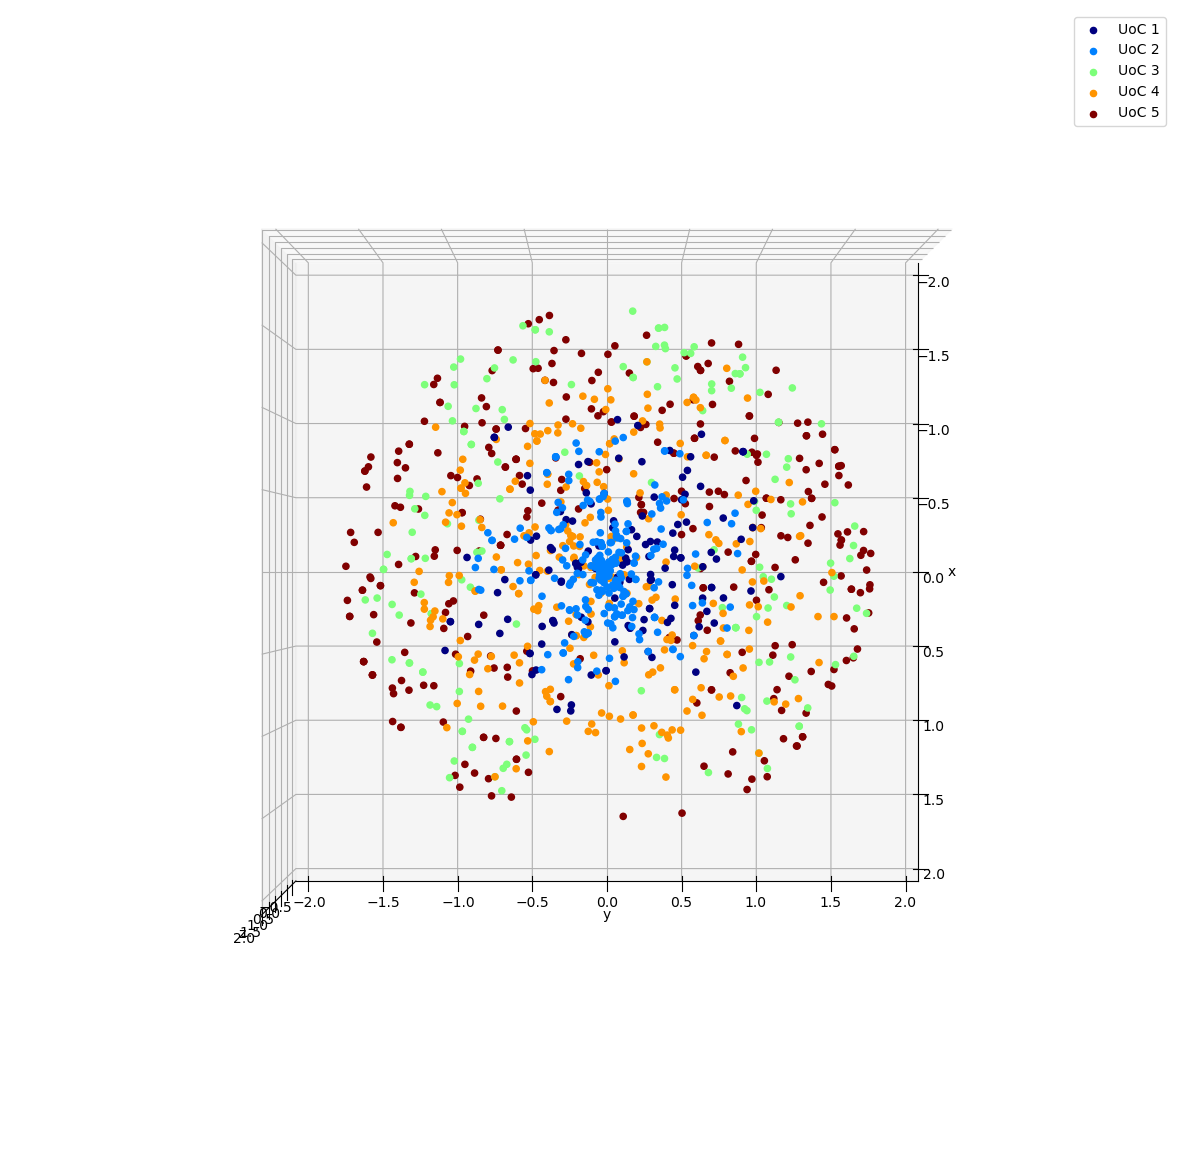

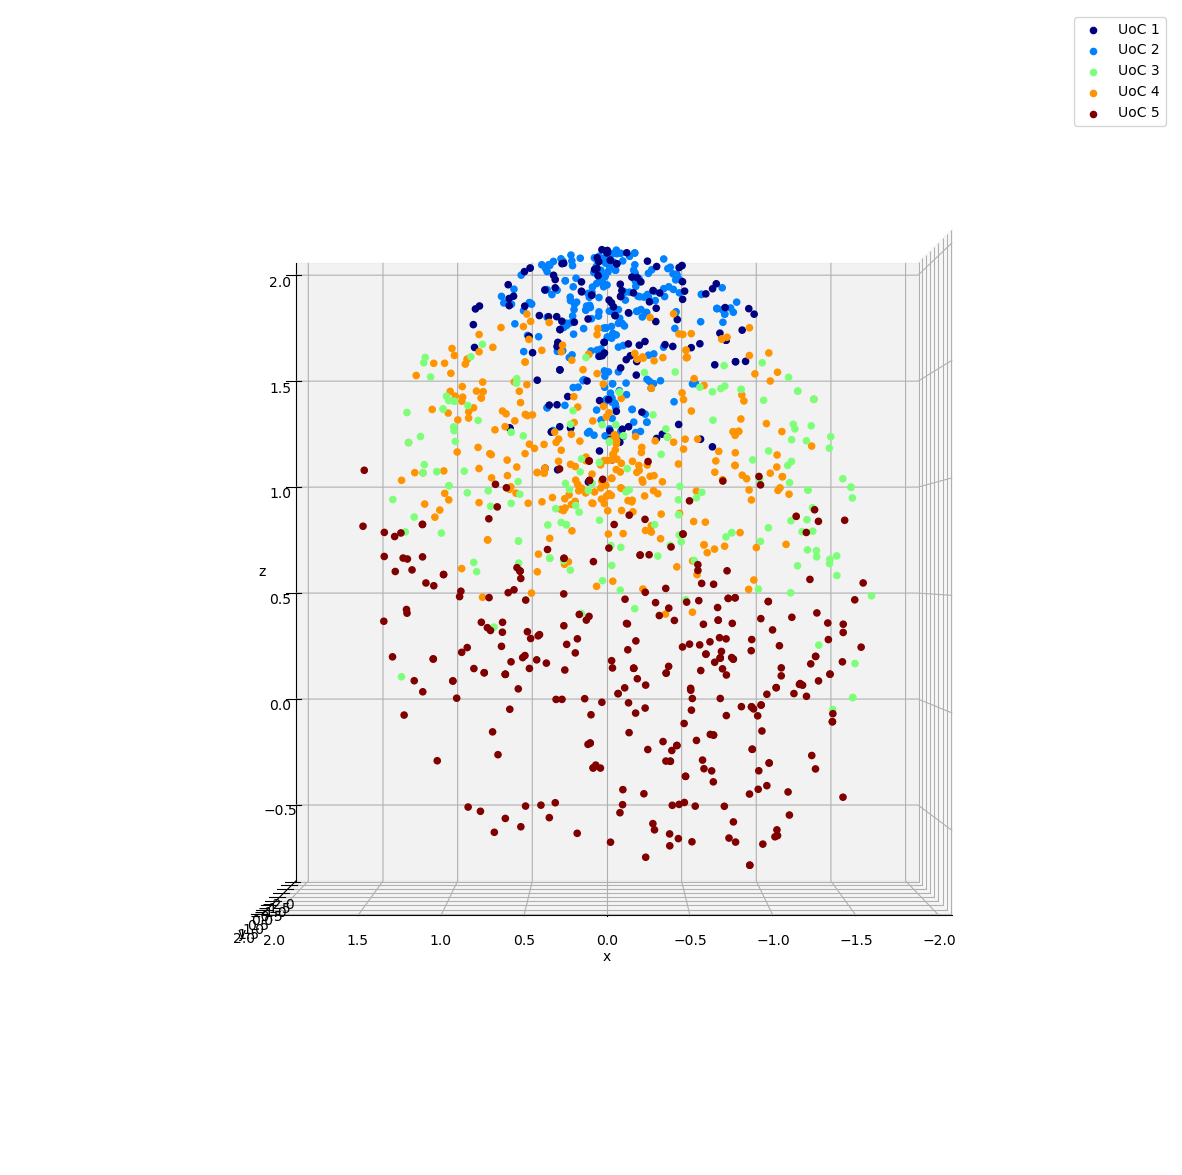

In [59]:
visualizer = Visualization_UoCs(defining_relative_level)
visualizer.plot_all_UoCs(90,0)
visualizer.plot_all_UoCs(0,90)

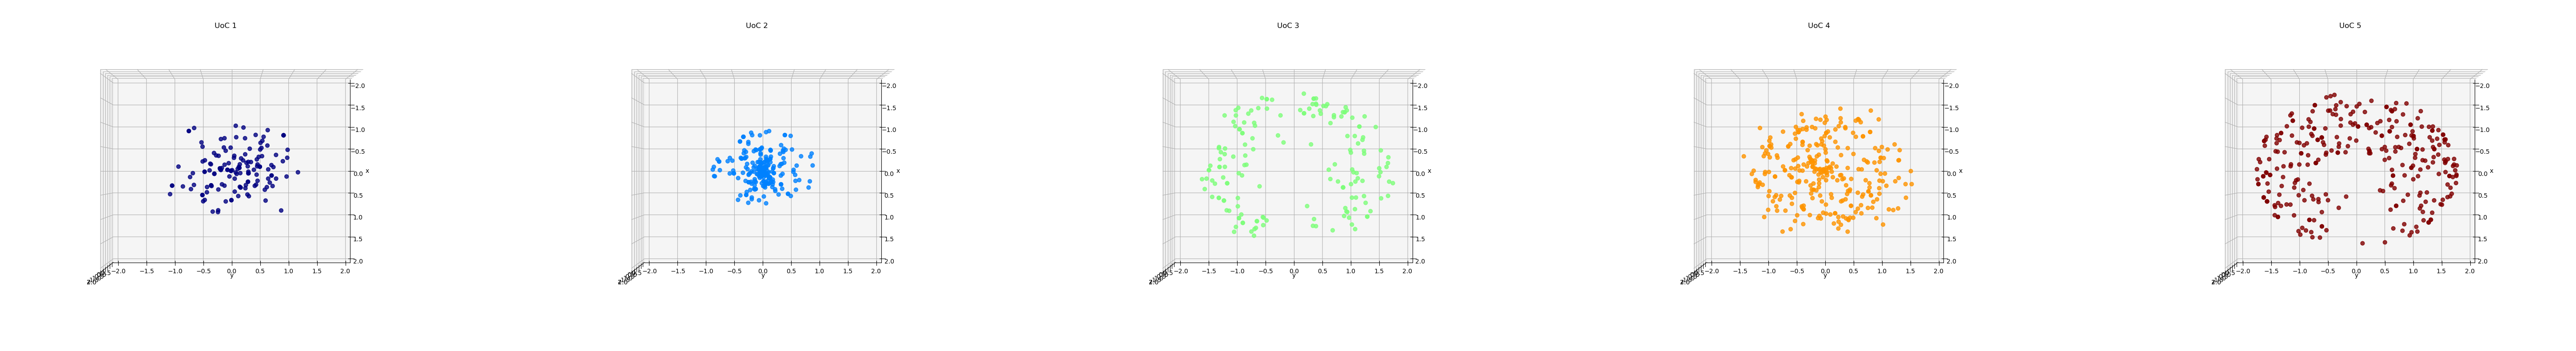

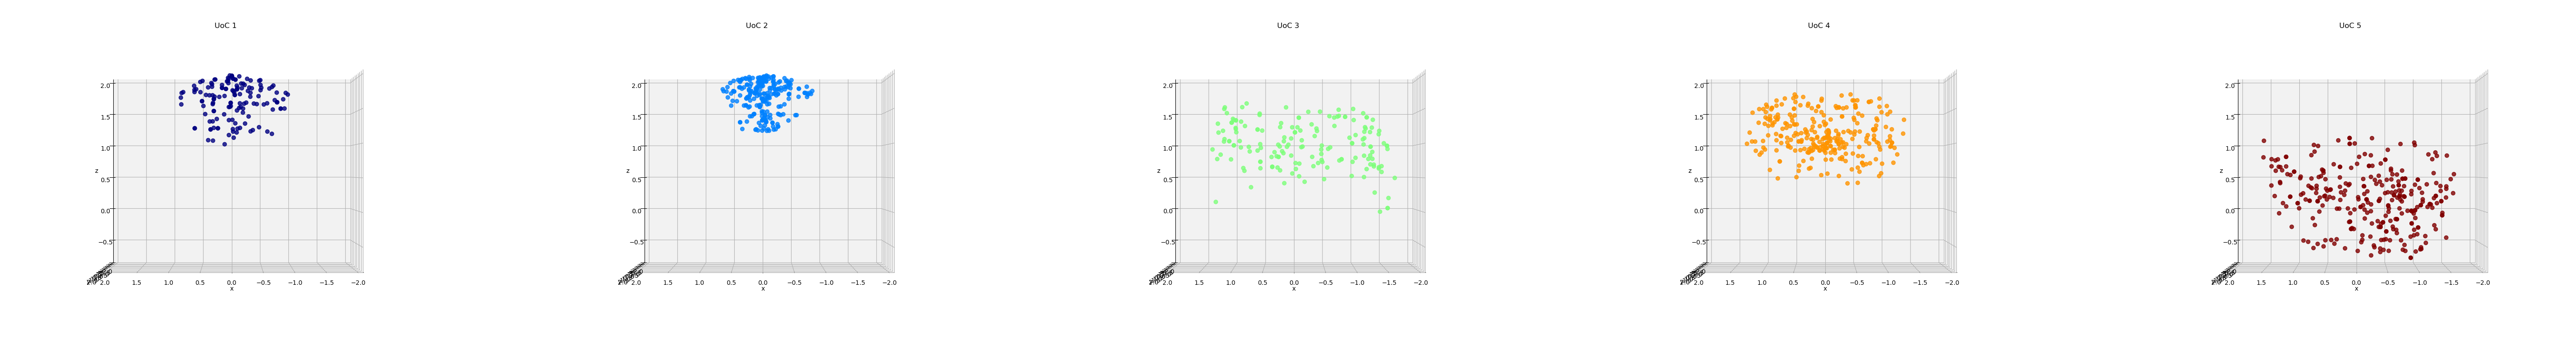

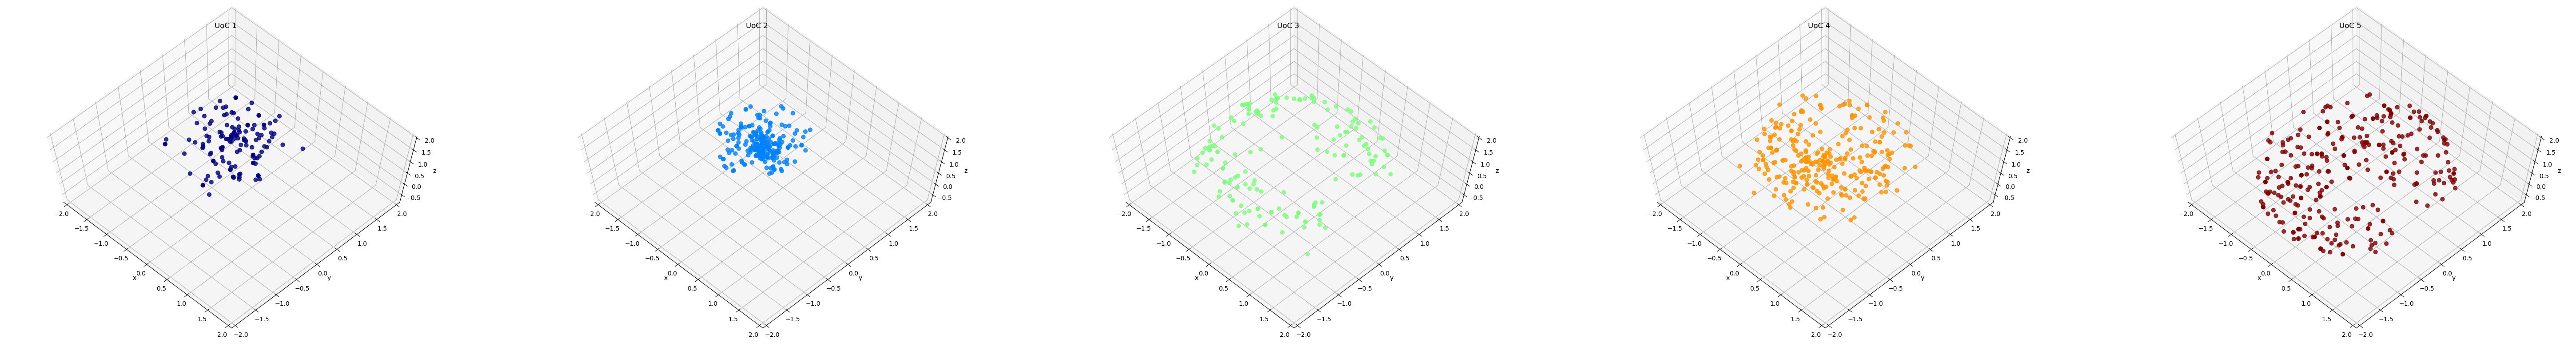

In [60]:
visualizer.plot_each_cluster(90,0)
visualizer.plot_each_cluster(0,90)
visualizer.plot_each_cluster(70,-45)